In [54]:
library(ggplot2, quietly = TRUE)
library(LaplacesDemon, quietly = TRUE)
library(glmnet, quietly = TRUE)
library(foreach, quietly = TRUE)
library(doParallel, quietly = TRUE)
library(quadprog, quietly = TRUE)
library(openxlsx, quietly = TRUE)
library(stringr, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(reticulate, quietly = TRUE)
library(jocre, quietly = TRUE)
library(knitr, quietly = TRUE)

library(reshape, quietly = TRUE)
library(MASS, quietly = TRUE)



In [55]:
## Old bias correction method is in code documentation, here is a new approach, closer to Xu 2017


stratSamplerWithReplacement <- function(W){
    
    treatmentDurationEachUnit <- rowSums(W)
    
    nonZeroDurations <- treatmentDurationEachUnit[treatmentDurationEachUnit != 0]
    
    howManyToSampleFromEachDuration <- table(treatmentDurationEachUnit)
    
    controlUnits <- which(treatmentDurationEachUnit==0)
    
    numTreatedUnits <- length(which(treatmentDurationEachUnit!=0))
    
    treatedSample <- sample(controlUnits, size=numTreatedUnits, replace=FALSE)
    
    remainingControlUnits <- controlUnits[!(controlUnits %in% treatedSample)]
                                            
    controlSample <- sample(remainingControlUnits, 
        size=howManyToSampleFromEachDuration[1], replace=TRUE)
                                            
    treatmentDurationSampleNonZero <- sample(nonZeroDurations, numTreatedUnits, replace=FALSE)
    
    treatmentDurationSample <- c(rep(0, length(controlSample)), treatmentDurationSampleNonZero)
    
    finalSampleAndDuration <- cbind(c(controlSample, treatedSample), 
                                    treatmentDurationSample)
    
    return(finalSampleAndDuration)
    
}


newBiasSample <- function(Y, W, weightMatrix, B1){
    
    empDist <- colSums(W)/dim(W)[1]
    
    names(empDist) <- 1:dim(W)[2]

    pij <- sapply(empDist, FUN=function(x) rep(x, dim(W)[1]))
                  
    originalPropScores <- weight.to.propensity.score(weightMatrix, 
                                                     W=W)
    
    biasEstimates <- array(0, dim=c(dim(W), B1))
    
    for (b1 in 1:B1){
    
        bootSampInfo <- stratSamplerWithReplacement(W)
        
        rightOrderBootstrap <- bootSampInfo[order(bootSampInfo[,2]), 1]

        YBootstrapped <- Y[rightOrderBootstrap, ]

        WBootstrapped <- array(0, dim=dim(W))

        for (i in 1:dim(bootSampInfo)[1]){

            WBootstrapped[bootSampInfo[i, 1], 1:dim(W)[2] >= 
                          (dim(W)[2]-bootSampInfo[i, 2]+1)] <- 1

        }
        
        WBootstrapped <- WBootstrapped[rightOrderBootstrap, ]
        
        propScoresBootstrapped <- originalPropScores[rightOrderBootstrap, ]
        
        fixedWeights <- propScoresBootstrapped+pij*(1-propScoresBootstrapped)
                  
        weightMatrixBootstrapped <- propensity.score.to.weight(fixedWeights,
                                                   W=WBootstrapped)

        bootstrappedControlInfo <- completion_with_rank_estimation_validate_mu(
                                                      Y=YBootstrapped, 
                                                      W=WBootstrapped,  
                                    weight_matrix = weightMatrixBootstrapped,
                                                      initial_rank=40,
                                                      tolerance=1e-04, 
                                                      validation_max_iter=500,
                                                      min_iter=10,
                                                      max_iter=1000,
                                                      mu_grid=0,
                                                      K=5)
        
        
        survivalMatrix <- array(0, dim(WBootstrapped))
        
        survivalMatrix[rowSums(WBootstrapped) != 0,] <- 1
        

        estimator <- (YBootstrapped-bootstrappedControlInfo$L_hat)*survivalMatrix
                                     
        
        biasEstimates[, , b1] <- estimator
        
        }
    
    return(biasEstimates)
    
}

bootstrappedEstimateGenerator <- function(Y, W, weightMatrix, B1, B2){
    
    rightOrder <- order(rowSums(W))
    
    Y <- Y[rightOrder, ]
    
    W <- W[rightOrder, ]
    
    weightMatrix <- weightMatrix[rightOrder, ]
    
    epDistribution <- newBiasSample(Y=Y, W=W, weightMatrix=weightMatrix, B1=B1)
    
    fullModel <- completion_with_rank_estimation_validate_mu(
                                                      Y=Y, 
                                                      W=W,  
                                                      weight_matrix = weightMatrix,
                                                      initial_rank=40,
                                                      tolerance=1e-04, 
                                                      validation_max_iter=500,
                                                      min_iter=10,
                                                      max_iter=1000,
                                                      mu_grid=0,
                                                      K=5)
    
    untreatedCounterFactualMatrix <- fullModel$L_hat
    
    estimTreatmentEffect <- treat.estimator(Y, untreatedCounterFactualMatrix,
                                           W)
    
    controlResidualMatrix <- array(0, dim(W))
    
    fullModelResiduals <- Y-fullModel$L_hat
    
    justControlResiduals <- fullModelResiduals[which(
        rowSums(W) == 0), ]

    bsEstims <- array(0, c(B2, max(rowSums(W))))

    for (b2 in 1:B2){

        controlResidualSample <- justControlResiduals[
            sample(1:dim(justControlResiduals)[1],
                                       size=dim(justControlResiduals)[1],
                                       replace=T), ]


        theChosenETotal <- epDistribution[,, sample(1:dim(epDistribution)[3], size=1)]

        theChosenETotal[1:dim( controlResidualSample)[1], ] <- controlResidualSample

        perturbedUntreatedCounterfactuals <- (untreatedCounterFactualMatrix+
                                              theChosenETotal)


        bootstrappedModel <- completion_with_rank_estimation_validate_mu(
                                Y=perturbedUntreatedCounterfactuals, 
                                W=W,  
                                weight_matrix = weightMatrix,
                                initial_rank=40,
                                tolerance=1e-04, 
                                validation_max_iter=500,
                                min_iter=10,
                                max_iter=1000,
                                mu_grid=0,
                                K=5)

        boostrappedEstim <- treat.estimator(perturbedUntreatedCounterfactuals,
                                           bootstrappedModel$L_hat,
                                           W)

        bsEstims[b2, ] <- boostrappedEstim

    }
    
    finalbSamp <- t(apply(bsEstims, MARGIN=1, FUN=function(x) estimTreatmentEffect-x))
                          
    return(finalbSamp)
    
}



In [56]:
### use_python("/usr/bin/python3", required = T)

### For setting working directory
##setwd("../../../../Causal Inference with Propensity Scores/simulations_and_reports/parameters_and_compilation_code")


server_name <- Sys.info()['nodename']

params <- read.xlsx("parameters_and_descriptions.xlsx",
                            sheet="parameter_data", rowNames = T)

source('causal_inference_methods_code_corrupted.R')

mse_and_se_of_mse <- function(error_mat){
  
  squared_errors <- error_mat
  
  the_mse <- mean(squared_errors, na.rm=T)
  
  se_mse <- sqrt((sd(squared_errors, na.rm=T)^2)/prod(dim(squared_errors)))
  
  final_stuff <- c(the_mse, se_mse)
  
  names(final_stuff) <- c("mse", "se_mse")
  
  return(final_stuff)
  
}

twoEntriesToValParenth <- function(twoVals){ ### For formatting distance tables to LATEX
  
  paste(twoVals[1]," (",twoVals[2],")", sep="")
  
}

number_of_Es <- as.numeric(params["number_of_Es", ])

bootstrap_samps <- as.numeric(params["bootstrap_samps", ])

N <- as.numeric(params["N", ])

Time <- as.numeric(params["Time", ])

K <- as.numeric(params["K", ])

generatingModel <- params['generatingModel',]

lengthCutoff <- as.numeric(params['lengthCutoff',])

matrix_type <- c("tall", 'wide')[(Time > N)+1]

Time0 <- as.numeric(params["Time0", ])

rho_parameter <- as.numeric(params["rho_parameter", ])

tau <- as.numeric(params["tau", ])

propTreat <- as.numeric(params["prop_treat", ])

sigma_squared <- as.numeric(params["sigma_squared", ])

min_iter <- as.numeric(params["min_iter", ])

max_iter <- as.numeric(params["max_iter", ])

tolerance <- as.numeric(params["tolerance", ])

L_scaling <- as.numeric(params["L_scaling", ])

arg_max <- as.numeric(params["arg_max", ])

y_max <- as.numeric(params["y_max", ])

halfway_time <-as.numeric( params["halfway_time", ])

cutoff <- as.numeric(params["cutoff", ])

design <- params["design", ]

all_function_names <- as.character(ls.str())

treatment_function_names <- all_function_names[str_detect(all_function_names, pattern="delta_t_")]

bs_method_names <- all_function_names[str_detect(all_function_names, pattern="bs_")]

prob_func_names <- all_function_names[str_detect(all_function_names, pattern="prob_(?!func)")]

max_lag <- as.numeric(params["max_lag", ])

group_gap <- as.numeric(params["group_gap", ])

desired_coverage <- as.numeric(params["desired_coverage", ])

treatment_function <- get(treatment_function_names[str_detect(treatment_function_names, 
                                                              pattern=params["treatment_effect_function", ])])

bootstrap_method <- get(bs_method_names[str_detect(bs_method_names, 
                                                            pattern=params["bootstrap_method", ])])

link_func <- params["link_func", ]

prob_func <- get(prob_func_names[str_detect(prob_func_names, 
                                 pattern=link_func)])
##################### Fixed Parameter Simulations
##################################################
###################################################
#################################################

mus.chosen <- rep(NA, number_of_Es)

#### This will delinate treatment/control groups


In [57]:
## We have two models, and each can help is separate the treatment/control units
## We can e
betaEffect <- rep(1, K)

# qFuncParms = list(mean=c(-1,1), sd=1)

if (design=="staggered_adoption"){ 
  
  observed.params <- parameterMakerStaggered(N=N, Time=Time, propTreat=propTreat, 
                                               generatingModel = "Pois",
                                               K=K, lengthCutoff=lengthCutoff,
                                               glmBeta=rep(.5, K),
                                               qFunc=qexp, qFuncParms = list(rate=1))
  
  # norm(observed.params$trueWeightMatrix-observed.params$weightMatrixEst, 'F')/sqrt(prod(dim(observed.params$weightMatrixEst)))
  
  norm(observed.params$trueWeightMatrix-observed.params$weightMatrixEst, 'F')/sqrt(prod(dim(observed.params$weightMatrixEst)))
  
  xBeta <- covariateEffectComponent(covArray=observed.params$covArray, betaEffect)
  
  W <- observed.params$W
  
}else if (design=="block_treatment"){
  
  # mean=c(-.5*group_gap, .5*group_gap)
  
  observed.params <- parameterMakerBlock(N=N, Time=Time, Time0=Time0, propTreat=propTreat, 
                                           k=K,
                                           link_func=link_func,
                                           glmBeta=rep(.5, K),
                                           qFunc=qexp, qFuncParms = list(rate=1),
                                           prob_func = prob_func)
  
  xBeta <- covariateEffectComponent(covArray=observed.params$covArray, betaEffect)
  
  W <- observed.params$W
  
}

final.weight.matrix <- observed.params$trueWeightMatrix

tau_matrix <- t(apply(W, MARGIN=1, FUN=treated_matrix_creator, 
                      f_of_t=treatment_function, arg_max=arg_max, 
                      y_max=y_max, halfway_time=halfway_time, cutoff=cutoff, value=tau))

treatment_times <- sort(unique(dim(W)[2]-rowSums(W)+1))

treatment_times <- treatment_times[treatment_times <= dim(W)[2]]

delta_t <- treatment_function(1:(Time-(min(treatment_times)-1)),
                              arg_max=arg_max, 
                              y_max=y_max, halfway_time=halfway_time, cutoff=cutoff, value=tau)

autocorrelation_matrix <- make_rho_mat(rho=rho_parameter, p=dim(W)[2])

sig_to_noise_ratios <- c()

desired_clusters <- 8

max_available_clusters <- detectCores()

cl <- makeCluster(min(c(max_available_clusters, desired_clusters))-3)

registerDoParallel(cl)

L <- matrix(5, nrow=N, ncol=Time)  
 # L <- matrix(rexp(N*Time, .1), nrow=N, ncol=Time)

delta_t_estimates <- array(NA, dim=c(number_of_Es, length(delta_t)))
  

In [58]:
B1 <- 1
B2 <- 2

delta_t_estimates <- array(0, dim=c(number_of_Es, length(delta_t)))

### For Bias-correction approach
#boot_ests <- array(0, c(B2, length(delta_t), number_of_Es))

### For uncorrected approach
boot_ests <- array(NA, dim=c(bootstrap_samps, max(rowSums(W)), number_of_Es))

for (e in 1:number_of_Es){
    
  Y <- nortaNoise(number=N, corr_mat=autocorrelation_matrix,
                 desired_mean_matrix= L+tau_matrix*observed.params$W+.25*xBeta, 
                 distribution='gaussian',
                 scalar_sigma=sqrt(sigma_squared))
    
 # boot_ests[, , e] <- bootstrappedEstimateGenerator(Y=Y, W=W, weightMatrix=final.weight.matrix, 
  #                                                  B1=B1, B2=B2)
    
    
    #boot_ests[, , e] <- bootstrapCI(Y=Y, W=W, weightMatrix=final.weight.matrix, 
    #            bootstrap_samps=bootstrap_samps, method=completion_with_rank_estimation_validate_mu,
    #           initial_rank=40, tolerance=1e-04, validation_max_iter=500,
    #            min_iter=10, max_iter=1000, mu_grid=0, K=5)
    
    
  boot_ests[, , e] <- bootstrapCI(Y=Y, W=W, weightMatrix=final.weight.matrix, 
                bootstrap_samps=bootstrap_samps, method=completion_with_rank_estimation_validate_mu,
               initial_rank=40, tolerance=1e-04, validation_max_iter=500,
                min_iter=10, max_iter=1000, mu_grid=0, K=5)
    
  #theBias <- biasSampler(Y=Y, W=W, weight_matrix=final.weight.matrix, numberOfBiasSamples=100)
    
    
  #boot_ests[, , e] <- boot_ests[, , e]-theBias[sample(1:dim(theBias)[1], size=dim(boot_ests)[1], 
  #                                                    replace=T),]
    
  fullEstimateinfo <- completion_with_rank_estimation_validate_mu(Y=Y, W=W,  
                                                               weight_matrix = final.weight.matrix,
                                                               initial_rank=40,
                                                               tolerance=1e-04, 
                                                               validation_max_iter=500,
                                                               min_iter=10,
                                                               max_iter=1000,
                                                               mu_grid=0,
                                                               K=5)
    
    
    
    fullEstimator <- treat.estimator(Y, fullEstimateinfo$L_hat, W)
    
    delta_t_estimates[e,] <-   fullEstimator
    
    }

In [59]:
sum(W)/prod(dim(W))

[1] 0.05986667

In [60]:

if (! str_detect(params["bootstrap_method", ], 'cset')){

      ci_array <- apply(boot_ests, MARGIN=c(2, 3), FUN=bs_percentile_method, 
                        1-(1-desired_coverage)/length(delta_t))

    }else{

      ci_array <- plyr::aaply(boot_ests,  3,bs_cset_method ,desired_coverage, .drop=FALSE)

      ci_array <- aperm(ci_array, perm=c(2,3,1))

    }

    betweenTwoNumbers <- function(number, numberSandwich){

        return(numberSandwich[1] <= number & number <= numberSandwich[2])

    }

    we_do_good <- matrix(NA, nrow=dim(ci_array)[3], ncol=dim(ci_array)[2])

    for (iterationIndex in 1:dim(ci_array)[3]){

        whereWeHit <- c()

        for (colIndex in 1:dim(ci_array)[2]){

            theBounds <- ci_array[, colIndex, iterationIndex]

            whereWeHit <- as.vector(c(whereWeHit, betweenTwoNumbers(delta_t[colIndex], theBounds)))

        }

        we_do_good[iterationIndex,] <- whereWeHit

    }                    

    estimated_coverage <- colMeans(we_do_good)

    


In [61]:
ci_array[,,1]

0.3571429%,7.111790,14.82364,18.64494,19.04272,17.74188,16.28812,13.52460
99.64286%,8.245363,16.37517,20.66271,21.44340,20.47300,20.59495,17.36143


In [62]:
propTreat

[1] 0.5

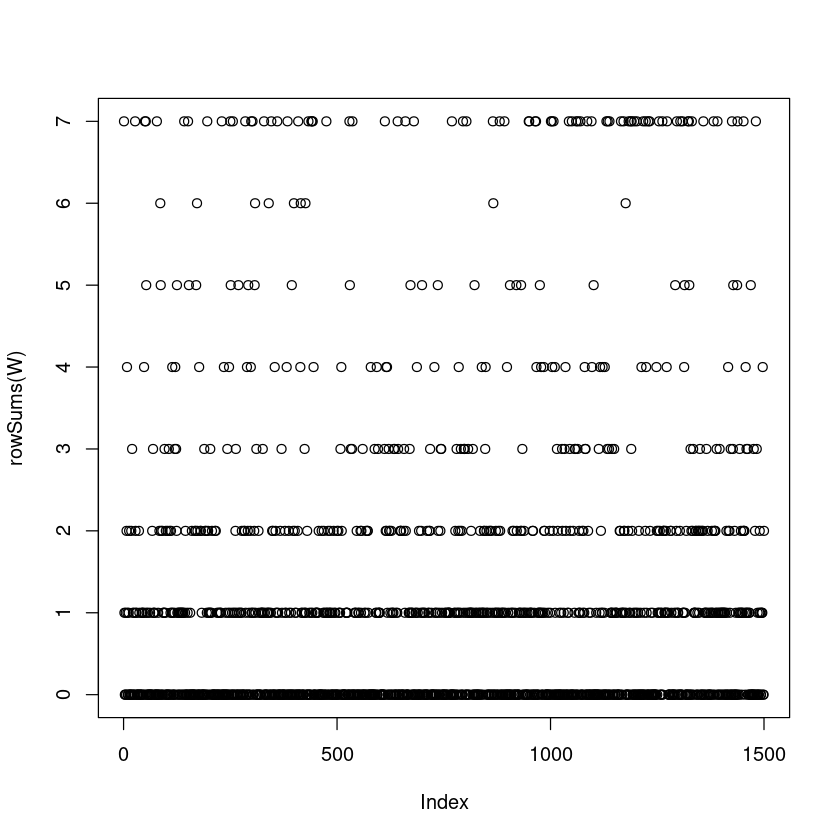

In [63]:
plot(rowSums(W))

In [64]:
estimated_coverage

[1] 1 1 1 1 1 1 1

# From Bootstrap to Full Data

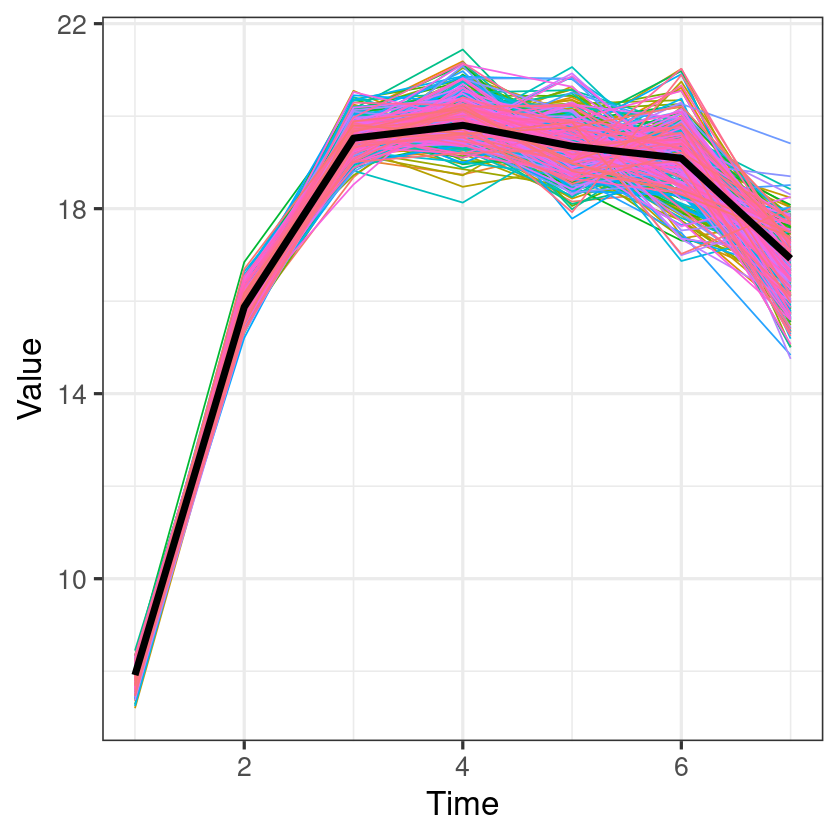

In [65]:
### FROM BOOTSTRAP TO FULL DATA              

                    
bootSimNumber <- 2
methodConsidered <- "ourMethod"

                    
deltaTConsidered <- delta_t_estimates[bootSimNumber,]
                    
bootstrapMethodConsidered <-  boot_ests[,,bootSimNumber]      
                    
                    
                    
iterationBootEstimates <- data.frame(melt(bootstrapMethodConsidered))   
                    
names(iterationBootEstimates) <- c("Iteration", "Time", "Value")                     
         
                    
                    
iterationBootEstimates <- iterationBootEstimates %>% mutate(Iteration = as.numeric(
    str_extract(as.character(Iteration), "[0-9]+$")),
    Time = as.numeric(str_extract(as.character(Time), "[0-9]+$")) )                   
                    
                    
delta_t_estimate_data <- cbind.data.frame(1:length(deltaTConsidered), deltaTConsidered)                    
                    
names(delta_t_estimate_data) <- c("Time", "Value")

ggplot(iterationBootEstimates, aes(x=Time, y=Value, color=factor(Iteration))) + geom_line()+
    geom_line(data=delta_t_estimate_data, aes(x=Time, y=Value, color='black'), lwd=2, color='black')+ 
theme_bw(base_size=20) + theme(legend.position = "none")   

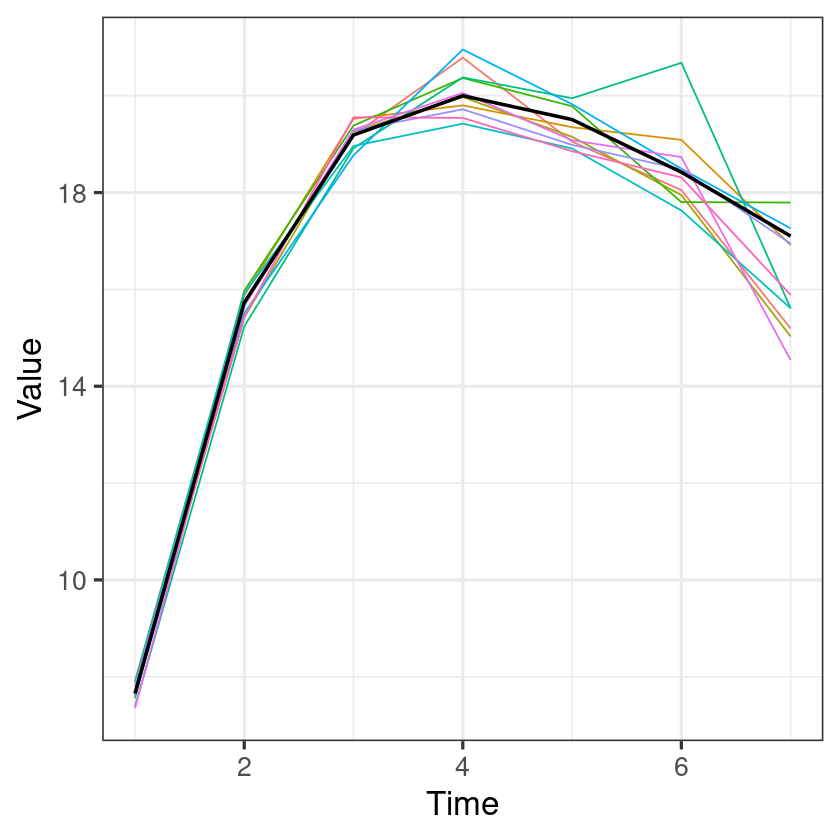

In [66]:
### FROM FULL DATA TO TRUTH                    
                    
iterationBootAverages <- data.frame(melt(delta_t_estimates[, ]))
                    
names(iterationBootAverages) <- c("Iteration", "Time", "Value")   
                    
iterationBootAverages <- iterationBootAverages %>% mutate(Iteration = as.numeric(
    str_extract(as.character(Iteration), "[0-9]+$")),
    Time = as.numeric(str_extract(as.character(Time), "[0-9]+$")) )                    

delta_t_data <- cbind.data.frame(1:length(delta_t), delta_t)
                    
names(delta_t_data) <- c("Time", "Value")

ggplot(iterationBootAverages, aes(x=Time, y=Value, color=factor(Iteration))) + geom_line()+
    geom_line(data=delta_t_data, aes(x=Time, y=Value, color='black'), lwd=1, color='black')+ 
theme_bw(base_size=20) + theme(legend.position = "none") 

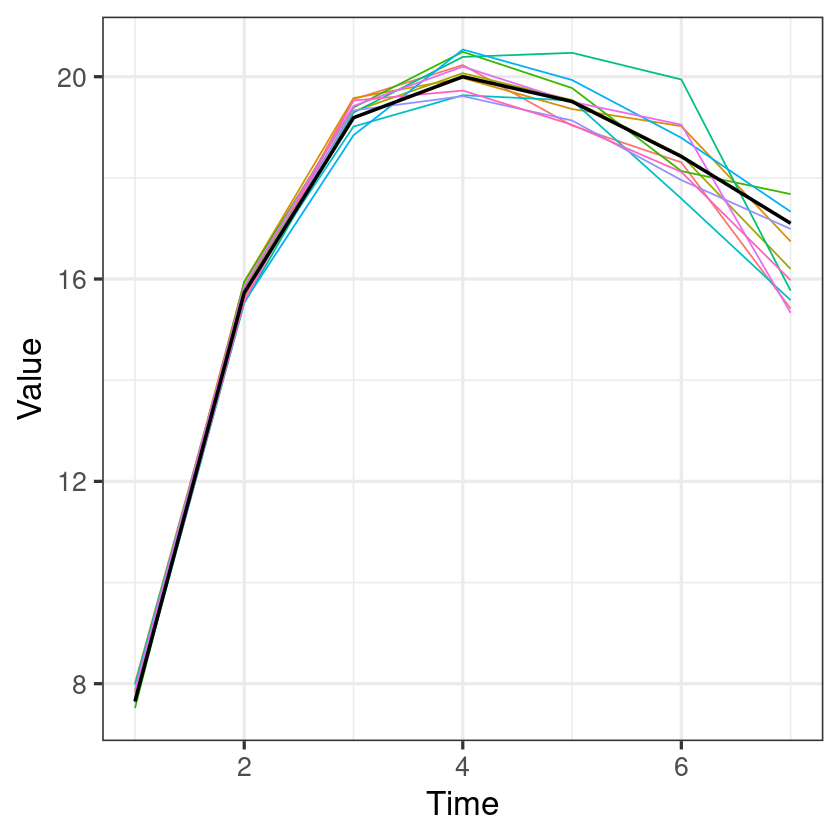

In [67]:
### FROM Bootstrap estimiates TO TRUTH                    
                    
averageOfBootEsts <- data.frame(melt(t(colMeans(boot_ests))))
                    
names(averageOfBootEsts) <- c("Iteration", "Time", "Value")   
                    
averageOfBootEsts <- averageOfBootEsts %>% mutate(Iteration = as.numeric(
    str_extract(as.character(Iteration), "[0-9]+$")),
    Time = as.numeric(str_extract(as.character(Time), "[0-9]+$")) )                    

delta_t_data <- cbind.data.frame(1:length(delta_t), delta_t)
                    
names(delta_t_data) <- c("Time", "Value")

ggplot(averageOfBootEsts, aes(x=Time, y=Value, color=factor(Iteration))) + geom_line()+
    geom_line(data=delta_t_data, aes(x=Time, y=Value, color='black'), lwd=1, color='black')+ 
theme_bw(base_size=20) + theme(legend.position = "none") 

In [68]:

averageBootEstsWithError <- averageOfBootEsts  %>% group_by(Iteration) %>% mutate(error=Value-delta_t)

iterationBootAveragesWithError <- iterationBootAverages %>% group_by(Iteration) %>% mutate(error=Value-delta_t)

In [69]:
mean(averageBootEstsWithError$error^2)
mean(iterationBootAveragesWithError$error^2)

[1] 0.3023062

[1] 0.485537

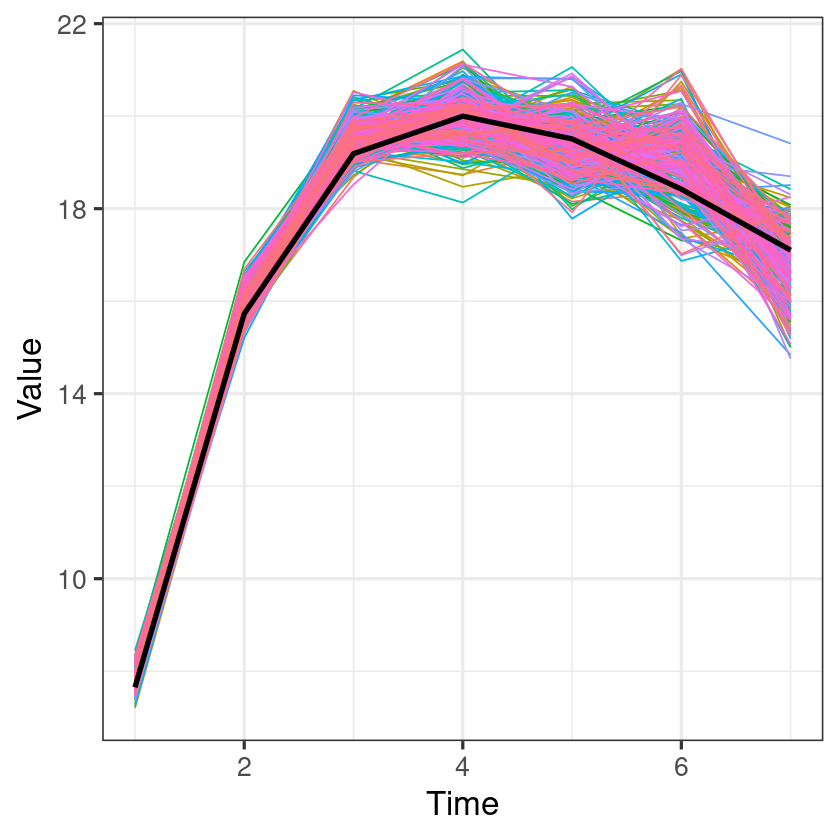

In [70]:
ggplot(iterationBootEstimates, aes(x=Time, y=Value, color=factor(Iteration))) + geom_line()+
    geom_line(data=delta_t_data, aes(x=Time, y=Value, color='black'), lwd=1.5, color='black')+ 
theme_bw(base_size=20) + theme(legend.position = "none")      

In [18]:
iterationBootEstimates %>% group_by(Time) %>% summarize(bootMean=mean(Value, na.rm=T))

Time,bootMean
<dbl>,<dbl>
1,7.727983
2,15.042498
3,19.447015
4,20.430551


In [19]:
iterationBootAverages %>% filter(Iteration==bootSimNumber)

Iteration,Time,Value
<dbl>,<dbl>,<dbl>
2,1,7.75728
2,2,15.02039
2,3,19.41435
2,4,20.36222
